# HESG Data usage - 3 - decision algorithm and heating schedule

## Introduction

This notebook is part of the HESG Data Usage package. Please refer to the whole repository available here:  
https://gitlab.com/es-catapult-ds/hesg-data-examples

Please refer to this repository for the license, python packages requirement and how to access data.

## Content of this notebook

This notebook shows an example of how access and use the HESG Data to display the requested temperature as used by the decision algorithm. This schedule corresponds to what is used by the algorithm to decide on the valve position and heat request.

It is assumed that the following files are in the working directory:
- eden1sensor.csv
- eden1heatingtargets.csv

## 1. Import the libraries

In [1]:
# CSV files are loaded with pandas
import pandas as pd

# plotting is done with matplotlib
import matplotlib.pyplot as plt
# this jupyter notebook command enables interactive plotting
%matplotlib notebook
# remove SettingWithCopyWarning warning message to avoid distraction
pd.set_option('mode.chained_assignment', None)

In [2]:
# load one month of one house from the whole sensor file
houseid = 76
try:
    df_sensor_selected = pd.read_csv("./df_sensor_selected.csv")
except FileNotFoundError:
    chunksize = 1000000
    filename = "./eden1sensor.csv"
    chunks = []
    useful_cols = ["houseid", "roomid", "sensortimestamp",
                   "roomtype",
                   "roomtimestamp",
                   "roomtemperature",
                   "roomdatastatus",
                   "radiator1surfacetemp",
                   "radiator1datastatus",
                   "radiator1timestamp",
                   "wrvswitchvariable",
                   "wrvdatastatus",
                   "wrvtimestamp",
                   "boilerdatastatus",
                   "boilerswitchonoff",
                   "boilertimestamp",
                   "gasmeterdatastatus",
                   "gasmeterreading",
                   "gasmetertimestamp",
                   "hotwaterdatastatus",
                   "hotwaterflowtemp",
                   "hotwaterreturn",
                   "hotwatertimestamp"
                   ]
    for chunk in pd.read_csv(filename,
                             usecols = useful_cols,
                             chunksize=chunksize):
        chunk = chunk[chunk["houseid"] == houseid]
        chunk["sensortimestamp"] =  pd.to_datetime(chunk["sensortimestamp"])
        chunk = chunk[(chunk["sensortimestamp"] >= "1 Mar 2019")
                     & (chunk["sensortimestamp"] < "14 Mar 2019")]
        print("loaded", len(chunk), "lines")
        if len(chunk):
            chunks.append(chunk)
    if len(chunks) == 1:
        df_sensor_selected = chunks[0]
    elif len(chunks) >= 2:
        df_sensor_selected = pd.concat(chunks)
    else:
        print("no line loaded")
    del chunks
    print("save it in a file for fast loading")
    df_sensor_selected.to_csv("./df_sensor_selected.csv", index=False) 


/home/caudron/anaconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3,4,5,6,8,9,12,13,15,16,18,19,20,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# the room id are translated into a more human-readable format. 
df_rooms = df_sensor_selected.groupby("roomid").first()
df_rooms["roomtype_indice"] = df_rooms.groupby("roomtype").cumcount()
df_rooms["roomname2"] = (df_rooms["roomtype"].astype(str).str.replace(" & ", "")
                         + df_rooms["roomtype_indice"].astype(str))
df_rooms = df_rooms[["roomname2"]]
df_sensor_selected["roomid"] = df_sensor_selected["roomid"].replace(df_rooms["roomname2"].to_dict())

## 3. Get the room temperature and the requested target temperatures

The room temperature is obtained as done in full details in the previous notebooks.

The requested target temperatures are obtained from the heatingtargets CSV file.

In [4]:
df_sensor_room = df_sensor_selected[df_sensor_selected["roomid"] == "Bedrooms0"]
df_roombox = df_sensor_room[["roomtimestamp",
                            "roomtemperature",
                            "roomdatastatus"]]
df_roombox["roomtimestamp"] = pd.to_datetime(df_roombox["roomtimestamp"])
df_roombox = df_roombox[df_roombox["roomdatastatus"] == "normal"]
period = ["1 Mar 2019", "6 Mar 2019"]
df_roombox = df_roombox[(df_roombox["roomtimestamp"] >= period[0]) 
                        & (df_roombox["roomtimestamp"] < period[1])]

<ipython-input-4-809335da4306>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_roombox["roomtimestamp"] = pd.to_datetime(df_roombox["roomtimestamp"])


In [6]:
df_heatingtargets = pd.read_csv("./eden1heatingtargets.csv")
# display the heating targets table
# for illustration only
df_heatingtargets

houseid                                             roomid  \
0           31  87bb526a48706f2634e39ca4cb399c170b869ae7a5c9fd...   
1           31  87bb526a48706f2634e39ca4cb399c170b869ae7a5c9fd...   
2           31  87bb526a48706f2634e39ca4cb399c170b869ae7a5c9fd...   
3           31  87bb526a48706f2634e39ca4cb399c170b869ae7a5c9fd...   
4           31  87bb526a48706f2634e39ca4cb399c170b869ae7a5c9fd...   
...        ...                                                ...   
55487      123  f9865e047e4a0db571e0a75e766d055005a3259fd9a6a2...   
55488      123  f9865e047e4a0db571e0a75e766d055005a3259fd9a6a2...   
55489      123  f9865e047e4a0db571e0a75e766d055005a3259fd9a6a2...   
55490      123  f9865e047e4a0db571e0a75e766d055005a3259fd9a6a2...   
55491      123  f9865e047e4a0db571e0a75e766d055005a3259fd9a6a2...   

                          timestamp                   lastupdated  max  min  \
0      2018-10-01 07:00:07.000+0000  2019-10-29 13:18:28.000+0000   21   19   
1      2018-10-01 12:00:34.000+0000  2019-10-29 13:18:28.000+0000   20   18   
2      2018-10-01 13:00:39.000+0000  2019-10-29 13:18:28.000+0000   21   19   
3      2018-10-01 14:00:45.000+0000  2019-10-29 13:18:28.000+0000   10    5   
4      2018-10-01 17:00:48.000+0000  2019-10-29 13:18:28.000+0000   21   19   
...                             ...                           ...  ...  ...   
55487  2019-08-24 13:19:22.000+0000  2019-10-29 13:18:27.000+0000   10    5   
55488  2019-09-28 08:09:41.000+0000  2019-10-29 13:18:28.000+0000   21   19   
55489  2019-09-28 11:00:08.000+0000  2019-10-29 13:18:28.000+0000   10    5   
55490  2019-09-28 15:01:19.000+0000  2019-10-29 13:18:28.000+0000   21   19   
55491  2019-09-28 20:00:24.000+0000  2019-10-29 13:18:28.000+0000   10    5   

       psmax  psmin  
0        NaN    NaN  
1        NaN    NaN  
2        NaN    NaN  
3        NaN    NaN  
4        NaN    NaN  
...      ...    ...  
55487    NaN    NaN  
55488    NaN    NaN  
55489    NaN    NaN  
55490    NaN    NaN  
55491    NaN    NaN  

[55492 rows x 8 columns]

In [7]:
# rename the room id
df_ht_selected = df_heatingtargets[df_heatingtargets["houseid"] == houseid]
df_ht_selected["roomid"] = df_ht_selected["roomid"].replace(df_rooms["roomname2"].to_dict())
# select the heating targets for the room "Bedrooms0" only
df_ht_selected = df_ht_selected[df_ht_selected["roomid"] == "Bedrooms0"]
# convert the timestamp into Datetime
df_ht_selected["timestamp"] = pd.to_datetime(df_ht_selected["timestamp"])

<ipython-input-7-98c863e177d2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ht_selected["roomid"] = df_ht_selected["roomid"].replace(df_rooms["roomname2"].to_dict())


The heating targets are defined as bloc of minimum - maximum temperatures for a period of time. The system will try to maintain the temperature inside this minimum - maximum temperature range.

The heatingtargets rows contains:
- the targets defined by the occupier ("max" and "min")
- the pseudo-targets defined by the decision algorithm to pre-heat the room such that the target temperature is reached at the correct time ("psmin", "psmax").

The timestamp corresponds to the beginning of the target bloc. The request stays the same until the next heating target information.

In [8]:
# when no pseudo-target is defined, set it up to the default value of 5 - 10.
df_ht_selected["psmax"] = df_ht_selected["psmax"].fillna(10)
df_ht_selected["psmin"] = df_ht_selected["psmin"].fillna(5)

## 4. Plot the heating targets

The algorithm-defined pseudo-targets are showing in cyan, the user-defined targets are showing in orange.

<IPython.core.display.Javascript object>


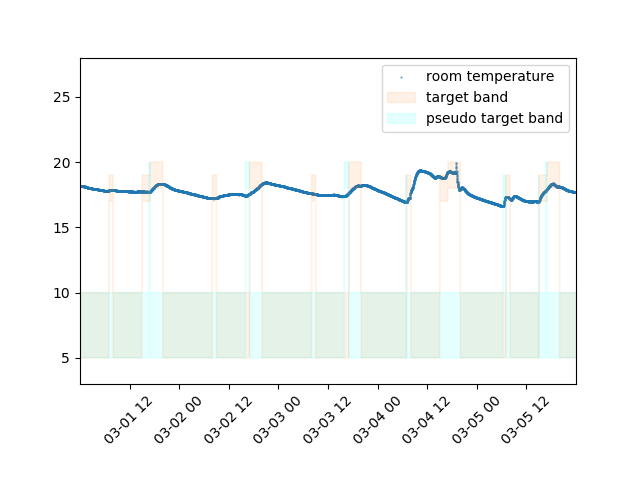

In [13]:
plt.close()
plt.scatter(df_roombox["roomtimestamp"], df_roombox["roomtemperature"],
           s=0.5, alpha=0.5, color="tab:blue", label="room temperature")
plt.fill_between(df_ht_selected["timestamp"], df_ht_selected["min"], df_ht_selected["max"],
            alpha=0.1, color="tab:orange", label="target band", step="post")
plt.fill_between(df_ht_selected["timestamp"], df_ht_selected["psmin"], df_ht_selected["psmax"],
            alpha=0.1, color="cyan", label="pseudo target band", step="post")
plt.xticks(rotation=45)
plt.xlim([df_roombox["roomtimestamp"].min(), df_roombox["roomtimestamp"].max()])
plt.ylim([3, 28])
plt.subplots_adjust(bottom=0.2)
plt.legend()

## 5. Resample the table for a better display

The heatingtargets table can be resampled to 1-minute resolution, and the default 5-10 value can be removed.

In [14]:
# resample the dataframe
df2 = df_ht_selected.copy()
df2 = df2[(df2["timestamp"] >= period[0]) 
        & (df2["timestamp"] < period[1])]
df2 = df2.set_index("timestamp").sort_index()
df2 = df2.resample("1min").last().fillna(method="ffill")
df2 = df2.replace({5:None, 10: None})

<IPython.core.display.Javascript object>


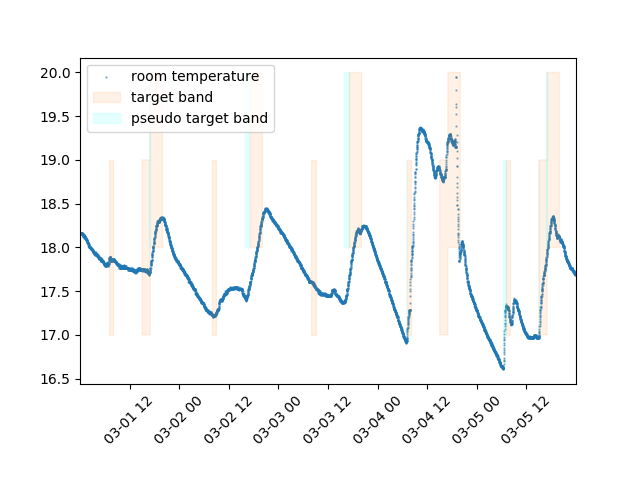

In [15]:
plt.close()
plt.scatter(df_roombox["roomtimestamp"], df_roombox["roomtemperature"],
           s=0.5, alpha=0.5, color="tab:blue", label="room temperature")
plt.fill_between(df2.index, df2["min"], df2["max"],
            alpha=0.1, color="tab:orange", label="target band")
plt.fill_between(df2.index, df2["psmin"], df2["psmax"],
            alpha=0.1, color="cyan", label="pseudo target band")
plt.xticks(rotation=45)
plt.xlim([df_roombox["roomtimestamp"].min(), df_roombox["roomtimestamp"].max()])
plt.subplots_adjust(bottom=0.2)
plt.legend()